In [1]:
# Imports
%load_ext autoreload
%autoreload 2

import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import sys

import bilby

# Add module
sys.path.append('../../modules')
from compute_omega import sample_dict_compute_injected_omega
from gwBackground_module import *

from constants import *
import equations
import redshiftPrior

In [3]:
from numba import jit

In [4]:
# Plot formatting
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 24
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]  

In [11]:
# Constants
# Mass Parameters
BBH_min = 5 # minimum BBH mass
BBH_max = 44 # maximum BBH mass

# Frequency Parameters
fmax = 3000
fref = 25

# Data Simulation Parameters
T_obs = 0.1 # observation time (in yrs)
duration = T_obs*60*60*24*365.25 # duration of each segment of data (in s)
N_segs = 1 # number of data segments to generate
sampling_frequency = 1024 # sampling rate (in Hz)
num_iterations = 12 # number of iterations to average Omega(f) over

In [6]:
# Prior dictionary for priors we *want*
priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp, minimum=0, maximum=z_max, name='redshift')
priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del priors['luminosity_distance']
del priors['chirp_mass']

14:42 bilby INFO    : Using aligned spin prior
14:42 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [7]:
priors_new = bilby.gw.prior.BBHPriorDict(aligned_spin=False)

14:42 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [8]:
# Calculate number of injections


def calculate_total_rate(priors):
    zs, p_dz = priors['redshift']._get_redshift_arrays()
    p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
    total_sum = np.sum(np.diff(zs) * p_dz_centers)
    return total_sum

def calculate_expected_num_events(T_obs, priors):
    '''
    T_obs : float
        observation time (in seconds)
    priors: bilby.core.prior.PriorDict
        bilby prior dictionary

    Returns:
    --------
    N : float
        Expected number of events in that time
    '''
    rate = calculate_total_rate(priors)
    return T_obs * rate
    

zs, p_dz = priors['redshift']._get_redshift_arrays()
N = calculate_expected_num_events(T_obs, priors)
print(N)

24046.357826358675 1 / yr


In [27]:
# "reference" prior dictionary
uniform_priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# uniform_priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=BBH_min, maximum=BBH_max)
uniform_priors['mass_1'] = bilby.core.prior.Uniform(minimum=BBH_min, maximum=BBH_max)
uniform_priors['mass_ratio'] = bilby.core.prior.Uniform(minimum=0, maximum=1)
uniform_priors['theta_jn'] = bilby.core.prior.Uniform(minimum=0, maximum=2*np.pi, name='theta_jn')
uniform_priors['chi_1'] = 0
uniform_priors['chi_2'] = 0
uniform_priors['redshift'] = redshiftPrior.BrokenPowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=zp,
                                                                       minimum=0, maximum=z_max, name='redshift')
uniform_priors['geocent_time'] = bilby.core.prior.Uniform(minimum=0, maximum=T_obs, name='geocent_time')
del uniform_priors['luminosity_distance']
del uniform_priors['chirp_mass']

14:47 bilby INFO    : Using aligned spin prior
14:47 bilby INFO    : No prior given, using default BBH priors in /Users/patrickmeyers/opt/anaconda3/envs/gw_general/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [37]:
# Draw samples
N_inj = 100_000 # np.random.poisson(N.value)
injections = uniform_priors.sample(N_inj)

m1s = injections['mass_1']
qs = injections['mass_ratio']
zs = injections['redshift']
m2s = []
Mtots = [] # m1 + m2
Ms = [] # chirp masses
for i in range(len(injections['mass_1'])):
    m2s.append(equations.calculate_m2(m1s[i], qs[i]))
    Mtots.append(equations.calculate_Mtot(m1s[i], m2s[i]))
    Ms.append(equations.calculate_M(m1s[i], m2s[i]))

# Set up waveform generator
# Waveform generator parameters
sampling_frequency=sampling_frequency
approximant='IMRPhenomD'

# Initialize waveform generator
waveform_generator = bilby.gw.WaveformGenerator(
    duration=2,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments={
        "waveform_approximant": 'IMRPhenomD',
        "reference_frequency": 50,
        "minimum_frequency": 1
    }
)

# Calculate non-weighted dEdf from uniform distributions
freqs_W = waveform_generator.frequency_array
OmegaGW_W = np.zeros(len(freqs_W))

dEdfs = []
for i in tqdm(range(N_inj)):
    inj_params = {}
    # Generate the individual parameters dictionary for each injection
    for k in injections.keys():
        if k == 'signal_type':
            continue
        try:
            inj_params[k] = injections[k]['content'][i]
        except:
            inj_params[k] = injections[k][i]

    # Get frequency domain waveform
    polarizations = waveform_generator.frequency_domain_strain(inj_params)

    # Final PSD of the injection
    dEdf = np.abs(polarizations['plus']) ** 2 + np.abs(polarizations['cross']) ** 2
    dEdfs.append(dEdf)


14:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
100%|███████████████████████████████████████████████| 100000/100000 [00:37<00:00, 2649.71it/s]


In [38]:
%%time
# Calculate Omega(f)
dEdfs = np.array(dEdfs)


# @jit
def get_weights(dEdfs, zs, m1s, m2s, qs, Mtots, Ms):
    weights = []
    for i in range(N_inj):
        z = zs[i]
        m1 = m1s[i]
        m2 = m2s[i]
        q = qs[i]
        Mtot = Mtots[i]
        M = Ms[i]

        # Probability of drawing {z, m1, m2}
        p_z = priors['redshift'].prob(z)
        p_m1 = priors['mass_1'].prob(m1)
        p_q = priors['mass_ratio'].prob(q)

        pdraw_z = uniform_priors['redshift'].prob(z)
        pdraw_m1 = uniform_priors['mass_1'].prob(m1)
        pdraw_q = uniform_priors['mass_ratio'].prob(q)

        # # Weight calculation
        # r = equations.R_SI(alpha, beta, z, zp, R0)
        # h = equations.Hubble_rate_SI(z, H0, omegaR, omegaM, omegak, omegaL)
        h0 = equations.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)

        wi = (p_z/pdraw_z) * (p_m1/pdraw_m1) * (p_q/pdraw_q)
        weights.append(wi)
    return np.array(weights)

    # Add to Omega_spectrum
    # OmegaGW_W += 2 * np.pi**2 * freqs_W**3 * dEdf / (3 * h0**2)
    

CPU times: user 186 ms, sys: 210 ms, total: 396 ms
Wall time: 397 ms


In [39]:
# %%time
weights = get_weights(dEdfs, zs, m1s, m2s, qs, Mtots, Ms)
h0 = equations.Hubble_rate_SI(0, H0, omegaR, omegaM, omegak, omegaL)

In [40]:

dEdf_sum = dEdfs.T @ weights
total_rate = calculate_total_rate(priors).value / (86400 * 365.25) # in units of [events s^{-1}]
OmegaGW_W = 2 * np.pi**2 * freqs_W**3 * dEdf_sum / (3 * h0**2)
Tobs_seconds = T_obs * 86400 * 365.25  # years to seconds
OmegaGW_W *= 2 * total_rate / N_inj

In [41]:
fs = []
omgws = []
for ii in range(1):
    freqs_psd, omega_gw_freq, injections = sample_dict_compute_injected_omega(priors, Tobs=T_obs, duration=2,
                                                                              f_ref=25, sampling_frequency=sampling_frequency,
                                       approximant='IMRPhenomD')
    fs.append(freqs_psd)
    omgws.append(omega_gw_freq)

2024-01-08 14:49:54.752 | INFO     | compute_omega:draw_injections:65 - We are averaging over 24046.357826358675 1 / yr waveforms for 0.1 years
14:49 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
2024-01-08 14:49:55.504 | INFO     | compute_omega:sample_dict_compute_injected_omega:106 - Compute the total injected Omega for 24082 injections
100%|█████████████████████████████████████████████████| 24082/24082 [00:10<00:00, 2281.44it/s]


/var/folders/pw/q58shg_d4vz37qn56ds0zjm40000gn/T/ipykernel_21256/2630508803.py:12: RuntimeWarning: invalid value encountered in divide
  plt.plot(OmegaGW_W / omega_gw_freq )


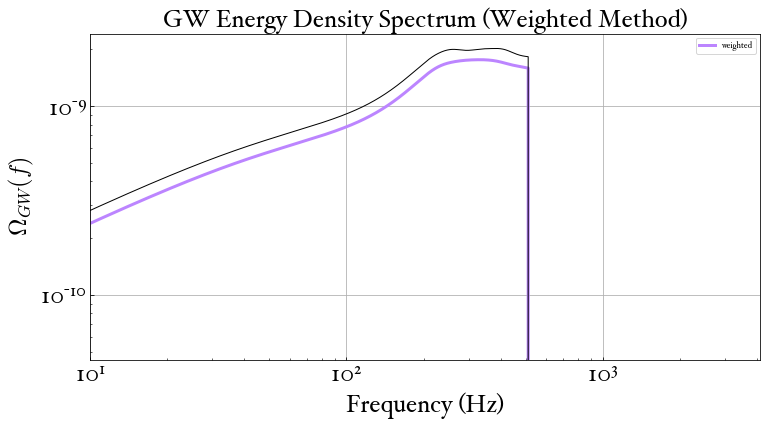

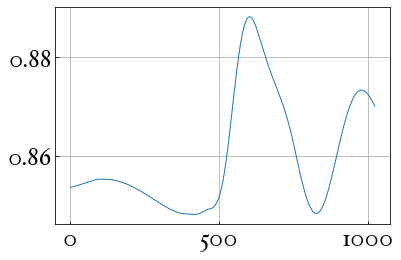

In [42]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 6))
ax.loglog(freqs_W, OmegaGW_W, color='#bc85ff', label='weighted', lw=3)
for ii in range(1):
    ax.loglog(fs[ii], omgws[ii], color='#000000', alpha=1)#, label='exact', alpha=0.1)
ax.set_title(r'GW Energy Density Spectrum (Weighted Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.set_xlim(10, 4096)
ax.legend()
plt.figure()
plt.plot(OmegaGW_W / omega_gw_freq )
plt.show()

In [ ]:
print("hi")

In [ ]:
omgws = np.array(omgws)

In [ ]:
omgws.shape

In [ ]:
plt.hist(np.log10(omgws[:, 100]), bins=20)
ax = plt.gca()
ax.axvline(np.log10(OmegaGW_W[100]), c='#bc85ff', lw=3)
ax.axvline(np.mean((np.log10(omgws[:, 100]))), c='k', ls='--', lw=3)
plt.show()

In [ ]:
np.mean(OmegaGW_W[100] / omgws[:, 100])

In [ ]:
np.nanmean((OmegaGW_W / omega_gw_freq)[:1000])

In [ ]:
# fig, ax = plt.subplots()
# ax.loglog(freqs_d, omega_gw_d, color='#d61c1c', label='Regimbau Method')
# ax.loglog(freqs_TC, OmegaGW_TC, color='#7dd4fa', label='Callister Method')
# ax.loglog(total_freqs_CB, total_OmegaGW_CB, color='#25cc33', label='Combined Method')
# ax.loglog(freqs_tf2, omega_gw_tf2, label='2/3 Power Law (Regimbau)', color='#991414')
# ax.loglog(freqs_TC, Omega_ref_TC*(freqs_TC/fref)**(2/3), label='2/3 Power Law (Callister)', color='#1f769c')
# ax.loglog(freqs_CB, Omega_ref_CB*(np.array(freqs_CB)/fref)**(2/3), label='2/3 Power Law (Combined)', color='#14751c')
# ax.set_title(r'GW Energy Density Spectrum')
# ax.set_xlabel(r'Frequency (Hz)')
# ax.set_ylabel(r'$\Omega_{GW}(f)$')
# ax.set_xlim(10, 1000)
# ax.legend()
# fig.show()